In [31]:
import os
import re
import random
import numpy as np
import pandas as pd

import smact
from smact.screening import smact_filter
from smact.utils.oxidation import ICSD24OxStatesFilter
from mp_api.client import MPRester
from pymatgen.core import Composition

SMACT filtering

In [ ]:
##Prepare element and anion data for SMACT filtering
#Prepare A and B
elements = smact.ordered_elements(1,83)
elements = [e for e in elements if e not in ['He','Ne','Ar','Kr','Xe']] #Remove noble gases
element_objects = smact.element_dictionary(elements)
element_data = [e[1] for e in element_objects.items()]

#Prepare X
anions = ['O','S','Se','Te']
anion_objects = smact.element_dictionary(anions)
anion_data = [e[1] for e in anion_objects.items()]

##We aim to perform smact filtering for AB2X4, ABBX4, and AAAX4 separately
##So we first need to generate all possible combinations of ABX, ABBX, and AAAX

##Find all possible ABX combinations for AB2X4 screening, excluding A=B, A=X, B=X
ABX_combinations = [[a,b,x] for a in element_data for b in element_data for x in anion_data if a!=b and a!=x and b!=x]

##Find all possible ABBX combinations for ABBX4 screening, excluding A=B, A=X, B=X
ABBX_combinations = [[a,b,b,x] for a in element_data for b in element_data for x in anion_data if a!=b and a!=x and b!=x]

##Find all possible AAAX combinations for AAAX4 screening, excluding A=X
AAAX_combinations = [[a,a,a,x] for a in element_data for x in anion_data if a!=x]

In [ ]:
##Generate oxidation states with low, medium and high commonality
ox_filter = ICSD24OxStatesFilter()
ox_filter.write(
    "data/SMACT/oxidation_states_icsd24_low.txt",
    consensus=3,
    include_zero=False,
    commonality='low',
    comment="Oxidation states of elements in the 2024 version of the ICSD - low",
)
ox_filter.write(
    "data/SMACT/oxidation_states_icsd24_medium.txt",
    consensus=3,
    include_zero=False,
    commonality='medium',
    comment="Oxidation states of elements in the 2024 version of the ICSD - medium",
)
ox_filter.write(
    "data/SMACT/oxidation_states_icsd24_high.txt",
    consensus=3,
    include_zero=False,
    commonality='high',
    comment="Oxidation states of elements in the 2024 version of the ICSD - high",
)

In [ ]:
##Uncomment this if you want to use only a subset of combinations for testing purposes
# ABX_combinations = random.sample(ABX_combinations, 10)
# ABBX_combinations = random.sample(ABBX_combinations, 10)
# AAAX_combinations = random.sample(AAAX_combinations, 10)

In [ ]:
##SMACT fitlering function
##For AB2X4
def screen_for_AB2X4(combinations, oxidation_state_thres):
    if oxidation_state_thres == "low":
        oxidation_states_list = ["data/SMACT/oxidation_states_icsd24_low.txt"]
    elif oxidation_state_thres == "medium":
        oxidation_states_list = ["data/SMACT/oxidation_states_icsd24_medium.txt"]
    elif oxidation_state_thres == "high":
        oxidation_states_list = ["data/SMACT/oxidation_states_icsd24_high.txt"]

    results = []
    for i in range(len(combinations)):
        result = smact_filter(combinations[i],threshold=4, oxidation_states_set=oxidation_states_list[0]) #perform smact filtering
        for j in range(len(result)):
            if result[j][2][2] == 4 and result[j][1][2] == -2: #screen for X4 and -2 oxidation state
                if result[j][1][0] >= 1 and result[j][1][1] >= 1: #screen for A and B oxidation states >= 1
                    if result[j][2][0] == 1 and result[j][2][1] == 2: #screen for A1 B2
                        results.append(result[j])
    return results
##For ABBX4
def screen_for_ABBX4(combinations, oxidation_state_thres):
    if oxidation_state_thres == "low":
        oxidation_states_list = ["data/SMACT/oxidation_states_icsd24_low.txt"]
    elif oxidation_state_thres == "medium":
        oxidation_states_list = ["data/SMACT/oxidation_states_icsd24_medium.txt"]
    elif oxidation_state_thres == "high":
        oxidation_states_list = ["data/SMACT/oxidation_states_icsd24_high.txt"]

    results = []
    for i in range(len(combinations)):
        result = smact_filter(combinations[i],threshold=4, oxidation_states_set=oxidation_states_list[0])
        for j in range(len(result)):
            if result[j][2][3] == 4 and result[j][1][3] == -2: #screen for X4 and -2 oxidation state
                if result[j][1][0] >= 1 and result[j][1][1] >= 1 and result[j][1][2] >= 1: #screen for A and B oxidation states >= 1
                    if result[j][1][1] != result[j][1][2]: #screen for B and B oxidation states not equal
                        if result[j][2][0] == 1 and result[j][2][1] == 1 and result[j][2][2] == 1: #screen for A1 B1 B1
                            results.append(result[j])
    return results
##For AAAX4
def screen_for_AAAX4(combinations, oxidation_state_thres):
    if oxidation_state_thres == "low":
        oxidation_states_list = ["data/SMACT/oxidation_states_icsd24_low.txt"]
    elif oxidation_state_thres == "medium":
        oxidation_states_list = ["data/SMACT/oxidation_states_icsd24_medium.txt"]
    elif oxidation_state_thres == "high":
        oxidation_states_list = ["data/SMACT/oxidation_states_icsd24_high.txt"]

    results = []
    for i in range(len(combinations)):
        result = smact_filter(combinations[i],threshold=4, oxidation_states_set=oxidation_states_list[0])
        for j in range(len(result)):
            if result[j][2][3] == 4 and result[j][1][3] == -2: #screen for X4 and -2 oxidation state
                if result[j][1][0] >= 1 and result[j][1][1] >= 1 and result[j][1][2] >= 1: #screen for A oxidation states >= 1
                    if result[j][2][0] == 1 and result[j][2][1] == 1 and result[j][2][2] == 1: #screen for A1 A1 A1
                        results.append(result[j])
    return results

In [ ]:
##Perform SMACT filtering
##Due to SMACT limitation, the kernel need to be restarted everytime the oxidation states file is changed.
##So the following lines need to be run separately for each oxidation states file.

##Low oxidation states commonality
# oxidation_state_thres = "low"
# smact_allowed_AB2X4 = screen_for_AB2X4(ABX_combinations, oxidation_state_thres)
# smact_allowed_ABBX4 = screen_for_ABBX4(ABBX_combinations, oxidation_state_thres)
# smact_allowed_AAAX4 = screen_for_AAAX4(AAAX_combinations, oxidation_state_thres)

##Medium oxidation states commonality
# oxidation_state_thes = "medium"
# smact_allowed_AB2X4 = screen_for_AB2X4(ABX_combinations, oxidation_states_thres)
# smact_allowed_ABBX4 = screen_for_ABBX4(ABBX_combinations, oxidation_state_thres)
# smact_allowed_AAAX4 = screen_for_AAAX4(AAAX_combinations, oxidation_state_thres)

##High oxidation states commonality
oxidation_state_thres = "high"
smact_allowed_AB2X4 = screen_for_AB2X4(ABX_combinations, oxidation_state_thres)
smact_allowed_ABBX4 = screen_for_ABBX4(ABBX_combinations, oxidation_state_thres)
smact_allowed_AAAX4 = screen_for_AAAX4(AAAX_combinations, oxidation_state_thres)

In [36]:
#Reduce SMACT format to compositions only and change to (A,B,X) format
def AB2X4_to_AB2X4(AB2X4_list):
    AB2X4_comps = []
    for i in range(len(AB2X4_list)):
        AB2X4_comps.append(AB2X4_list[i][0])
    return AB2X4_comps

def ABBX4_to_AB2X4(ABBX4_list):
    AB2X4_comps = []
    for i in range(len(ABBX4_list)):
        AB2X4_comps.append((ABBX4_list[i][0][0],ABBX4_list[i][0][1],ABBX4_list[i][0][3]))
    return AB2X4_comps

def AAAX4_to_AB2X4(AAAX4_list):
    AB2X4_comps = []
    for i in range(len(AAAX4_list)):
        AB2X4_comps.append((AAAX4_list[i][0][0],AAAX4_list[i][0][0],AAAX4_list[i][0][3]))
    return AB2X4_comps

In [37]:
##Change format
smact_allowed_AB2X4_comps = AB2X4_to_AB2X4(smact_allowed_AB2X4)
smact_allowed_AB2X4_comps_from_ABBX4 = ABBX4_to_AB2X4(smact_allowed_ABBX4)
smact_allowed_AB2X4_comps_from_AAAX4 = AAAX4_to_AB2X4(smact_allowed_AAAX4)

##Combine ABBX4 and AAAX4 lists with AB2X4 list
smact_allowed_all_comps = smact_allowed_AB2X4_comps + smact_allowed_AB2X4_comps_from_ABBX4 + smact_allowed_AB2X4_comps_from_AAAX4

In [38]:
##Find unique compositions
def find_unique_comps(allowed_comps):
    unique_comps = []
    for i in range(len(allowed_comps)):
        if allowed_comps[i] not in unique_comps:
            unique_comps.append(allowed_comps[i])
    return unique_comps

In [39]:
smact_allowed_all_unique_comps = find_unique_comps(smact_allowed_all_comps)

In [40]:
smact_allowed_oxide_comps = sorted([comp for comp in smact_allowed_all_unique_comps if comp[2] == 'O'])
smact_allowed_sulfide_comps = sorted([comp for comp in smact_allowed_all_unique_comps if comp[2] == 'S'])
smact_allowed_selenide_comps = sorted([comp for comp in smact_allowed_all_unique_comps if comp[2] == 'Se'])
smact_allowed_telluride_comps = sorted([comp for comp in smact_allowed_all_unique_comps if comp[2] == 'Te'])

In [41]:
len(smact_allowed_oxide_comps),len(smact_allowed_sulfide_comps),len(smact_allowed_selenide_comps),len(smact_allowed_telluride_comps)

(508, 508, 494, 397)

Save SMACT allowed compositions into csv

In [ ]:
pd.DataFrame(smact_allowed_oxide_comps).to_csv(f"data/SMACT/smact_allowed_oxide_comps_{oxidation_state_thres}}.csv", index=False, header=False)
pd.DataFrame(smact_allowed_sulfide_comps).to_csv(f"data/SMACT/smact_allowed_sulfide_comps_{oxidation_state_thres}.csv", index=False, header=False)
pd.DataFrame(smact_allowed_selenide_comps).to_csv(f"data/SMACT/smact_allowed_selenide_comps_{oxidation_state_thres}.csv", index=False, header=False)
pd.DataFrame(smact_allowed_telluride_comps).to_csv(f"data/SMACT/smact_allowed_telluride_comps_{oxidation_state_thres}.csv", index=False, header=False)

Save SMACT allowed compositions in POSCAR format for further MACE calculations, the POSCAR will not be created here but will be created using MACE calculation script in calculations_scripts/MACE/MACE_calculation.py

In [43]:
##Prepare data in POSCAR format for further MACE calculations
def change_to_poscar_format(smact_list):
    poscar_format = []
    for i in range(len(smact_list)):
        poscar_format.append(' '.join(ele for ele in smact_list[i]))
    return poscar_format

smact_allowed_oxide_comps_poscar = change_to_poscar_format(smact_allowed_oxide_comps)
smact_allowed_sulfide_comps_poscar = change_to_poscar_format(smact_allowed_sulfide_comps)
smact_allowed_selenide_comps_poscar = change_to_poscar_format(smact_allowed_selenide_comps)
smact_allowed_telluride_comps_poscar = change_to_poscar_format(smact_allowed_telluride_comps)

In [44]:
pd.DataFrame(smact_allowed_oxide_comps_poscar).to_csv(f"data/SMACT/smact_allowed_oxide_comps_{oxidation_state_thres}_poscar.csv", index=False, header=False)
pd.DataFrame(smact_allowed_sulfide_comps_poscar).to_csv(f"data/SMACT/smact_allowed_sulfide_comps_{oxidation_state_thres}_poscar.csv", index=False, header=False)
pd.DataFrame(smact_allowed_selenide_comps_poscar).to_csv(f"data/SMACT/smact_allowed_selenide_comps_{oxidation_state_thres}_poscar.csv", index=False, header=False)
pd.DataFrame(smact_allowed_telluride_comps_poscar).to_csv(f"data/SMACT/smact_allowed_telluride_comps_{oxidation_state_thres}_poscar.csv", index=False, header=False)

Materials Project (MP)

In [3]:
##Query AB2X4 and A3X4 spinels from Materials Project database
with MPRester("G76W9BmY62dEoc8zYnQBd9KvZCWCZUQf") as mpr:
    mp_exp_all_AB2X4 = mpr.materials.summary.search(formula="AB2C4",spacegroup_symbol="Fd-3m",theoretical="False")
    mp_exp_all_A3X4 = mpr.materials.summary.search(formula="A3B4",spacegroup_symbol="Fd-3m",theoretical="False")

mp_exp_all_data = mp_exp_all_AB2X4 + mp_exp_all_A3X4

Retrieving SummaryDoc documents: 100%|██████████| 10/10 [00:00<00:00, 332881.27it/s]


In [4]:
##Get formula and mpid for all queried materials
mp_exp_all_formulas = [mat.formula_pretty for mat in mp_exp_all_data]
mp_exp_all_mpid = [mat.material_id for mat in mp_exp_all_data]

##Change to iupac formula using Pymatgen
mp_exp_all_iupac_formula=[]
for i in mp_exp_all_formulas:
    comp=Composition(i)
    mp_exp_all_iupac_formula.append(comp.iupac_formula.replace(" ",""))
mp_exp_all_iupac_unique_formula=sorted(list(set(mp_exp_all_iupac_formula)))

In [5]:
##Function to convert iupac formula to (A,B,X) format
def iupac_to_ABX(iupac_formula):
    comps = []
    comps_others = []
    for i in range(len(iupac_formula)):
        split = re.findall(r'([A-Z][a-z]*)(\d*)', iupac_formula[i])
        if len(split) == 3:
            if split[0][1] == '1' and split[1][1] == '2' and split[2][1] == '4': #screen for A1 B2 X4
                comps.append((split[0][0], split[1][0], split[2][0]))
            elif split[0][1] == '2' and split[1][1] == '1' and split[2][1] == '4': #screen for B2 A1 X4
                comps.append((split[1][0], split[0][0], split[2][0]))
            elif split[0][1] == '4' and split[1][1] == '1' and split[2][1] == '2': #screen for X4 A1 B2
                comps.append((split[1][0], split[2][0], split[0][0]))
            elif split[0][1] == '4' and split[1][1] == '2' and split[2][1] == '1': #screen for X4 B2 A1
                comps.append((split[2][0], split[1][0], split[0][0]))
            elif split[0][1] == '2' and split[1][1] == '4' and split[2][1] == '1': #screen for B2 X4 A1
                comps.append((split[2][0], split[0][0], split[1][0]))
            elif split[0][1] == '1' and split[1][1] == '4' and split[2][1] == '2': #screen for A1 X4 B2
                comps.append((split[0][0], split[2][0], split[1][0]))
        elif len(split) == 2:
            if split[0][1] == '3' and split[1][1] == '4': #screen for A3 X4
                comps.append((split[0][0], split[0][0], split[1][0]))
            elif split[0][1] == '4' and split[1][1] == '3': #screen for X4 A3
                comps.append((split[1][0], split[1][0], split[0][0]))
        else:
            comps_others.append(iupac_formula[i])
    return comps, comps_others

In [6]:
##Change to (A,B,X) format
mp_exp_all_unique_AB2X4, mp_exp_others = iupac_to_ABX(mp_exp_all_iupac_unique_formula)

##Separate into oxide, sulfide, selenide, telluride, and other spinels
mp_exp_oxide = sorted([comp for comp in mp_exp_all_unique_AB2X4 if comp[2] == 'O'])
mp_exp_sulfide = sorted([comp for comp in mp_exp_all_unique_AB2X4 if comp[2] == 'S'])
mp_exp_selenide = sorted([comp for comp in mp_exp_all_unique_AB2X4 if comp[2] == 'Se'])
mp_exp_telluride = sorted([comp for comp in mp_exp_all_unique_AB2X4 if comp[2] == 'Te'])
mp_exp_others = sorted([comp for comp in mp_exp_all_unique_AB2X4 if comp[2] not in ['O','S','Se','Te']])

In [7]:
##Number of experimentally known spinels in MP database
print("Experimentally known spinels in MP database:")
print(f"Oxides: {len(mp_exp_oxide)}")
print(f"Sulfides: {len(mp_exp_sulfide)}")
print(f"Selenides: {len(mp_exp_selenide)}")
print(f"Tellurides: {len(mp_exp_telluride)}")
print(f"Others: {len(mp_exp_others)}")

Experimentally known spinels in MP database:
Oxides: 60
Sulfides: 54
Selenides: 29
Tellurides: 4
Others: 38


In [8]:
##Save to .csv
pd.DataFrame(mp_exp_oxide).to_csv(f"data/MP/mp_exp_oxide.csv", index=False, header=False)
pd.DataFrame(mp_exp_sulfide).to_csv(f"data/MP/mp_exp_sulfide.csv", index=False, header=False)
pd.DataFrame(mp_exp_selenide).to_csv(f"data/MP/mp_exp_selenide.csv", index=False, header=False)
pd.DataFrame(mp_exp_telluride).to_csv(f"data/MP/mp_exp_telluride.csv", index=False, header=False)
pd.DataFrame(mp_exp_others).to_csv(f"data/MP/mp_exp_others.csv", index=False, header=False)

ICSD

In [9]:
## Import ICSD data
df_icsd_1=pd.read_csv('data/ICSD/CSV_split/Spinel_01_20.csv')
df_icsd_2=pd.read_csv('data/ICSD/CSV_split/Spinel_20_40.csv')
df_icsd_3=pd.read_csv('data/ICSD/CSV_split/Spinel_40_60.csv')
df_icsd_4=pd.read_csv('data/ICSD/CSV_split/Spinel_60_80.csv')
df_icsd_5=pd.read_csv('data/ICSD/CSV_split/Spinel_80_100.csv')
df_icsd=pd.concat([df_icsd_1,df_icsd_2,df_icsd_3,df_icsd_4,df_icsd_5],ignore_index=True)

In [10]:
##Change from ICSD structured formula to composition using Pymatgen
icsd_comps = [Composition(comps) for comps in df_icsd['StructuredFormula']]

##Change to IUPAC formula, if not possible use reduced formula
icsd_iupac_and_reduced_formula = []
for i in range(len(icsd_comps)):
    try:
        icsd_iupac_and_reduced_formula.append(icsd_comps[i].iupac_formula)
    except:
        pass
        icsd_iupac_and_reduced_formula.append(icsd_comps[i].reduced_formula)

In [11]:
##Split formula into elements and numbers to make it easier to screen for A3X4 and AB2X4
icsd_iupac_and_reduced_formula_split = []
for i in range(len(icsd_iupac_and_reduced_formula)):
    icsd_iupac_and_reduced_formula_split.append(re.findall(r'([A-Za-z]+)([\d\.]+)',icsd_iupac_and_reduced_formula[i]))

##Screen for A3X4 and AB2X4 compositions
icsd_A3X4_combinations = [comp for comp in icsd_iupac_and_reduced_formula_split if len(comp)==2] ##Select only A3X4 compositions
icsd_AB2X4_combinations = [comp for comp in icsd_iupac_and_reduced_formula_split if len(comp)==3] ##Select only AB2X4 compositions

In [12]:
##Function to reorder the formula to AB2X4 ordering
def reorder_A3X4(comb_list):
    reordered_combs = []
    for i in range(len(comb_list)):
        combs = comb_list[i]
        a, x = combs[0][1], combs[1][1]
        if min(float(a), float(x)) == float(a):
            combs = [combs[0], combs[1]]
        elif min(float(a), float(x)) == float(x):
            combs = [combs[1], combs[0]]
        reordered_combs.append(combs)
    return reordered_combs

def reorder_AB2X4(comb_list):
    reordered_combs = []
    for i in range(len(comb_list)):
        combs = comb_list[i]
        a, b, x = combs[0][1], combs[1][1], combs[2][1]
        if min(float(a), float(b), float(x)) == float(a):
            if min(float(b),float(x)) == float(b):
                combs = [combs[0], combs[1], combs[2]]
            elif min(float(b),float(x)) == float(x):
                combs = [combs[0], combs[2], combs[1]]
        elif min(float(a), float(b), float(x)) == float(b):
            if min(float(a),float(x)) == float(a):
                combs = [combs[1], combs[0], combs[2]]
            elif min(float(a),float(x)) == float(x):
                combs = [combs[1], combs[2], combs[0]]
        elif min(float(a), float(b), float(x)) == float(x):
            if min(float(a),float(b)) == float(a):
                combs = [combs[2], combs[0], combs[1]]
            elif min(float(a),float(b)) == float(b):
                combs = [combs[2], combs[1], combs[0]]
        reordered_combs.append(combs)
    return reordered_combs

In [13]:
##Reorder
icsd_reordered_A3X4_combinations = reorder_A3X4(icsd_A3X4_combinations)
icsd_reordered_AB2X4_combinations = reorder_AB2X4(icsd_AB2X4_combinations)

##Change to (A,B,X) format
icsd_AB2X4_compositions_from_A3X4 = [(ele[0][0],ele[0][0],ele[1][0]) for ele in icsd_reordered_A3X4_combinations]
icsd_AB2X4_compositions_from_AB2X4 = [(ele[0][0],ele[1][0],ele[2][0]) for ele in icsd_reordered_AB2X4_combinations]
icsd_all_AB2X4_compositions = icsd_AB2X4_compositions_from_A3X4 + icsd_AB2X4_compositions_from_AB2X4

In [14]:
##Function to find unique compositions
def find_unique_compositions(comps):
    unique_comps = []
    for i in range(len(comps)):
        if comps[i] not in unique_comps:
            unique_comps.append(comps[i])
    return unique_comps

In [15]:
##Find unique AB2X4 compositions
icsd_all_unique_AB2X4_compositions = sorted(find_unique_compositions(icsd_all_AB2X4_compositions))

In [16]:
icsd_exp_oxide = [comp for comp in icsd_all_unique_AB2X4_compositions if comp[2] == 'O']
icsd_exp_sulfide = [comp for comp in icsd_all_unique_AB2X4_compositions if comp[2] == 'S']
icsd_exp_selenide = [comp for comp in icsd_all_unique_AB2X4_compositions if comp[2] == 'Se']
icsd_exp_telluride = [comp for comp in icsd_all_unique_AB2X4_compositions if comp[2] == 'Te']
icsd_exp_others = [comp for comp in icsd_all_unique_AB2X4_compositions if comp[2] not in ['O','S','Se','Te']]

In [17]:
##This is tricky, I perform manual check and found that:
##For oxides, I found that MnLi2O4 and GaMg2O4 don't exist. So they need to be removed.
icsd_exp_oxide.remove(('Mn','Li','O'))
icsd_exp_oxide.remove(('Ga','Mg','O'))

##Also for sulfides, I found that MIn2S4 seems strange since there is no M element. This also needs to be removed.
icsd_exp_sulfide.remove(('M','In','S'))

In [18]:
##Number of experimentally known spinels in ICSD database
print("Experimentally known spinels in ICSD database:")
print(f"Oxides: {len(icsd_exp_oxide)}")
print(f"Sulfides: {len(icsd_exp_sulfide)}")
print(f"Selenides: {len(icsd_exp_selenide)}")
print(f"Tellurides: {len(icsd_exp_telluride)}")
print(f"Others: {len(icsd_exp_others)}")

Experimentally known spinels in ICSD database:
Oxides: 124
Sulfides: 69
Selenides: 34
Tellurides: 4
Others: 13


In [19]:
##Save to .csv
pd.DataFrame(icsd_exp_oxide).to_csv('data/ICSD/icsd_oxide.csv',index=False)
pd.DataFrame(icsd_exp_sulfide).to_csv('data/ICSD/icsd_sulfide.csv',index=False)
pd.DataFrame(icsd_exp_selenide).to_csv('data/ICSD/icsd_selenide.csv',index=False)
pd.DataFrame(icsd_exp_telluride).to_csv('data/ICSD/icsd_telluride.csv',index=False)
pd.DataFrame(icsd_exp_others).to_csv('data/ICSD/icsd_others.csv',index=False)

Combine MP and ICSD data

In [20]:
##Make MP and ICSD data into pandas dataframe for easier comparison
df_mp_exp_oxide = pd.DataFrame(mp_exp_oxide)
df_mp_exp_sulfide = pd.DataFrame(mp_exp_sulfide)
df_mp_exp_selenide = pd.DataFrame(mp_exp_selenide)
df_mp_exp_telluride = pd.DataFrame(mp_exp_telluride)
df_mp_exp_others = pd.DataFrame(mp_exp_others)

df_icsd_exp_oxide = pd.DataFrame(icsd_exp_oxide)
df_icsd_exp_sulfide = pd.DataFrame(icsd_exp_sulfide)
df_icsd_exp_selenide = pd.DataFrame(icsd_exp_selenide)
df_icsd_exp_telluride = pd.DataFrame(icsd_exp_telluride)
df_icsd_exp_others = pd.DataFrame(icsd_exp_others)

In [21]:
##Merge MP and ICSD data to find union compositions
df_mp_icsd_exp_oxide = pd.merge(df_mp_exp_oxide, df_icsd_exp_oxide, how='outer')
df_mp_icsd_exp_sulfide = pd.merge(df_mp_exp_sulfide, df_icsd_exp_sulfide, how='outer')
df_mp_icsd_exp_selenide = pd.merge(df_mp_exp_selenide, df_icsd_exp_selenide, how='outer')
df_mp_icsd_exp_telluride = pd.merge(df_mp_exp_telluride, df_icsd_exp_telluride, how='outer')
df_mp_icsd_exp_others = pd.merge(df_mp_exp_others, df_icsd_exp_others, how='outer')

In [22]:
##Number of experimentally known spinels in MP and ICSD database
print("Experimentally known spinels in MP and ICSD database:")
print(f"Oxides: {len(df_mp_icsd_exp_oxide)}")
print(f"Sulfides: {len(df_mp_icsd_exp_sulfide)}")
print(f"Selenides: {len(df_mp_icsd_exp_selenide)}")
print(f"Tellurides: {len(df_mp_icsd_exp_telluride)}")
print(f"Others: {len(df_mp_icsd_exp_others)}")

Experimentally known spinels in MP and ICSD database:
Oxides: 124
Sulfides: 72
Selenides: 34
Tellurides: 4
Others: 47


Save MP and ICSD data to csv

In [23]:
##Since we focus only on oxides, sulfides, selenides, and tellurides, we will not consider other spinels in the following analysis
df_mp_icsd_exp_oxide.to_csv('data/MP_ICSD/mp_icsd_exp_oxide.csv',index=False,header=False)
df_mp_icsd_exp_sulfide.to_csv('data/MP_ICSD/mp_icsd_exp_sulfide.csv',index=False,header=False)
df_mp_icsd_exp_selenide.to_csv('data/MP_ICSD/mp_icsd_exp_selenide.csv',index=False,header=False)
df_mp_icsd_exp_telluride.to_csv('data/MP_ICSD/mp_icsd_exp_telluride.csv',index=False,header=False)

Plots allowed chemical space with known compositions

In [24]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import font_manager

In [25]:
##Import experimental and SMACT allowed data
df_mp_icsd_oxide = pd.read_csv("data/MP_ICSD/mp_icsd_exp_oxide.csv", header=None)
df_mp_icsd_sulfide = pd.read_csv("data/MP_ICSD/mp_icsd_exp_sulfide.csv", header=None)
df_mp_icsd_selenide = pd.read_csv("data/MP_ICSD/mp_icsd_exp_selenide.csv", header=None)
df_mp_icsd_telluride = pd.read_csv("data/MP_ICSD/mp_icsd_exp_telluride.csv", header=None)

df_smact_allowed_oxide_low = pd.read_csv("data/SMACT/smact_allowed_oxide_comps_low.csv", header=None)
df_smact_allowed_sulfide_low = pd.read_csv("data/SMACT/smact_allowed_sulfide_comps_low.csv", header=None)
df_smact_allowed_selenide_low = pd.read_csv("data/SMACT/smact_allowed_selenide_comps_low.csv", header=None)
df_smact_allowed_telluride_low = pd.read_csv("data/SMACT/smact_allowed_telluride_comps_low.csv", header=None)

df_smact_allowed_oxide_medium = pd.read_csv("data/SMACT/smact_allowed_oxide_comps_medium.csv", header=None)
df_smact_allowed_sulfide_medium = pd.read_csv("data/SMACT/smact_allowed_sulfide_comps_medium.csv", header=None)
df_smact_allowed_selenide_medium = pd.read_csv("data/SMACT/smact_allowed_selenide_comps_medium.csv", header=None)
df_smact_allowed_telluride_medium = pd.read_csv("data/SMACT/smact_allowed_telluride_comps_medium.csv", header=None)

df_smact_allowed_oxide_high = pd.read_csv("data/SMACT/smact_allowed_oxide_comps_high.csv", header=None)
df_smact_allowed_sulfide_high = pd.read_csv("data/SMACT/smact_allowed_sulfide_comps_high.csv", header=None)
df_smact_allowed_selenide_high = pd.read_csv("data/SMACT/smact_allowed_selenide_comps_high.csv", header=None)
df_smact_allowed_telluride_high = pd.read_csv("data/SMACT/smact_allowed_telluride_comps_high.csv", header=None)

In [26]:
##Prepare X and Y for plotting
x_mp_icsd_oxide = [e[0] for e in df_mp_icsd_oxide.iloc]
y_mp_icsd_oxide = [e[1] for e in df_mp_icsd_oxide.iloc]
x_mp_icsd_sulfide = [e[0] for e in df_mp_icsd_sulfide.iloc]
y_mp_icsd_sulfide = [e[1] for e in df_mp_icsd_sulfide.iloc]
x_mp_icsd_selenide = [e[0] for e in df_mp_icsd_selenide.iloc]
y_mp_icsd_selenide = [e[1] for e in df_mp_icsd_selenide.iloc]
x_mp_icsd_telluride = [e[0] for e in df_mp_icsd_telluride.iloc]
y_mp_icsd_telluride = [e[1] for e in df_mp_icsd_telluride.iloc]
x_smact_allowed_oxide_low = [e[0] for e in df_smact_allowed_oxide_low.iloc]
y_smact_allowed_oxide_low = [e[1] for e in df_smact_allowed_oxide_low.iloc]
x_smact_allowed_sulfide_low = [e[0] for e in df_smact_allowed_sulfide_low.iloc]
y_smact_allowed_sulfide_low = [e[1] for e in df_smact_allowed_sulfide_low.iloc]
x_smact_allowed_selenide_low = [e[0] for e in df_smact_allowed_selenide_low.iloc]
y_smact_allowed_selenide_low = [e[1] for e in df_smact_allowed_selenide_low.iloc]
x_smact_allowed_telluride_low = [e[0] for e in df_smact_allowed_telluride_low.iloc]
y_smact_allowed_telluride_low = [e[1] for e in df_smact_allowed_telluride_low.iloc]

x_smact_allowed_oxide_medium = [e[0] for e in df_smact_allowed_oxide_medium.iloc]
y_smact_allowed_oxide_medium = [e[1] for e in df_smact_allowed_oxide_medium.iloc]
x_smact_allowed_sulfide_medium = [e[0] for e in df_smact_allowed_sulfide_medium.iloc]
y_smact_allowed_sulfide_medium = [e[1] for e in df_smact_allowed_sulfide_medium.iloc]
x_smact_allowed_selenide_medium = [e[0] for e in df_smact_allowed_selenide_medium.iloc]
y_smact_allowed_selenide_medium = [e[1] for e in df_smact_allowed_selenide_medium.iloc]
x_smact_allowed_telluride_medium = [e[0] for e in df_smact_allowed_telluride_medium.iloc]
y_smact_allowed_telluride_medium = [e[1] for e in df_smact_allowed_telluride_medium.iloc]

x_smact_allowed_oxide_high = [e[0] for e in df_smact_allowed_oxide_high.iloc]
y_smact_allowed_oxide_high = [e[1] for e in df_smact_allowed_oxide_high.iloc]
x_smact_allowed_sulfide_high = [e[0] for e in df_smact_allowed_sulfide_high.iloc]
y_smact_allowed_sulfide_high = [e[1] for e in df_smact_allowed_sulfide_high.iloc]
x_smact_allowed_selenide_high = [e[0] for e in df_smact_allowed_selenide_high.iloc]
y_smact_allowed_selenide_high = [e[1] for e in df_smact_allowed_selenide_high.iloc]
x_smact_allowed_telluride_high = [e[0] for e in df_smact_allowed_telluride_high.iloc]
y_smact_allowed_telluride_high = [e[1] for e in df_smact_allowed_telluride_high.iloc]

In [27]:
##Prepare x and y axis tick labels
df_elements_by_group=pd.read_csv("data/elements_by_group.csv",header=None)
list_elements_by_group=df_elements_by_group[0].values.tolist()
x_label=[]
y_label=[]
x_newline='\n'
y_space='     '
for i in range(len(list_elements_by_group)):
    if i%2==0:
        x_label.append(list_elements_by_group[i])
        y_label.append(list_elements_by_group[i])
    else:
        x_label.append(x_newline+list_elements_by_group[i])
        y_label.append(list_elements_by_group[i]+y_space)

In [28]:
##Text settings
#Font
font_manager.fontManager.addfont('font/ARIAL.TTF')
plt.rcParams['font.family'] = 'Arial'
#Text size
title_size=14
axes_label_size=12
ticks_label_size=9.5
legend_size=12
txt_size=11

##Figure settings
fig_size=(10, 10)
aspect_ratio='equal'
grid_color = '0.2'

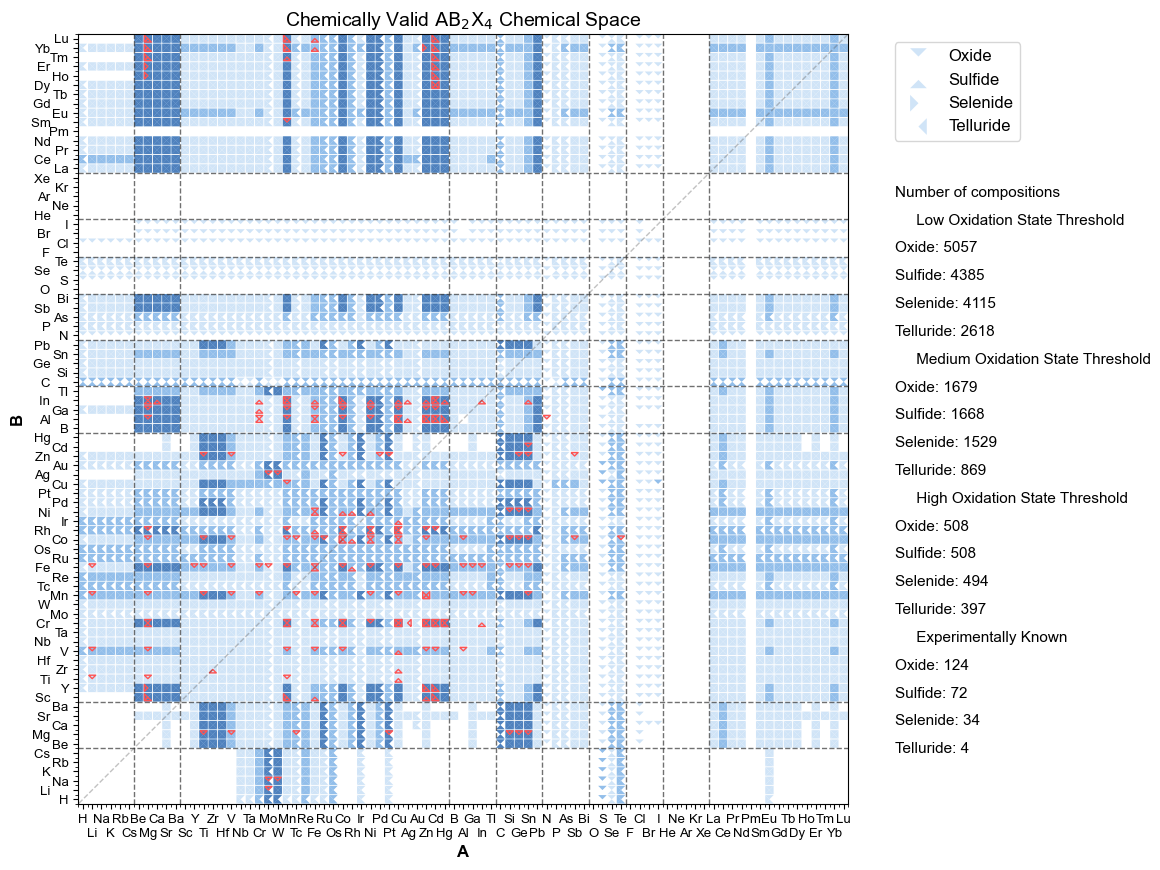

In [29]:
##Plotting Chemically Valid AB2X4 Chemical Space
##This plot was further modified in PowerPoint for better visualization, so the final version may look slightly different

#Marker settings
marker_oxide = [[-1,1],[0,0],[1,1],[-1,1]]#upper
marker_sulfide = [[-1,-1],[0,0],[1,-1],[-1,-1]]#lower
marker_selenide = [[-1,-1],[0,0],[-1,1],[-1,-1]]#left
marker_telluride = [[1,-1],[0,0],[1,1],[1,-1]]#right
#Colors
color_ox_threshold = ["#D0E4F7",'#92BEEA','#4F81BD']#blue

##Plotting
fig,ax=plt.subplots(figsize=fig_size)
ax.set_aspect(aspect_ratio)
ax.set_xlim([-0.5,82.5])
ax.set_ylim([-0.5,82.5])
#Set X and Y ticks to be elements sorted by group
ax.plot(list_elements_by_group,list_elements_by_group,'-',linewidth=0)
ax.set_xticks(list_elements_by_group,x_label,fontsize=ticks_label_size)
ax.set_yticks(list_elements_by_group,y_label,fontsize=ticks_label_size)
ax.set_xlabel('A',fontsize=axes_label_size, fontweight='bold')
ax.set_ylabel('B',fontsize=axes_label_size, fontweight='bold')
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
#Set grid lines to separate element groups
custom_grid = [5.5, 10.5, 39.5, 44.5, 49.5, 54.5, 58.5, 62.5, 67.5]
for x in custom_grid:
    ax.axvline(x=x, linestyle='--', color=grid_color, linewidth=1, alpha=0.7)
    ax.axhline(y=x, linestyle='--', color=grid_color, linewidth=1, alpha=0.7)
#Diagonal line
x_diagonal=np.linspace(-10,100,10)
y_diagonal=x_diagonal
ax.plot(x_diagonal,y_diagonal,'--',color=grid_color,linewidth=1,alpha=0.3)
#Low oxidation state threshold
ax.scatter(x_smact_allowed_oxide_low,y_smact_allowed_oxide_low,marker=marker_oxide,edgecolor='None',c=color_ox_threshold[0],label='Oxide')
ax.scatter(x_smact_allowed_sulfide_low,y_smact_allowed_sulfide_low,marker=marker_sulfide,edgecolor='None',c=color_ox_threshold[0],label='Sulfide')
ax.scatter(x_smact_allowed_selenide_low,y_smact_allowed_selenide_low,marker=marker_selenide,edgecolor='None',c=color_ox_threshold[0],label='Selenide')
ax.scatter(x_smact_allowed_telluride_low,y_smact_allowed_telluride_low,marker=marker_telluride,edgecolor='None',c=color_ox_threshold[0],label='Telluride')
#Medium oxidation state threshold
ax.scatter(x_smact_allowed_oxide_medium,y_smact_allowed_oxide_medium,marker=marker_oxide,edgecolor='None',c=color_ox_threshold[1])
ax.scatter(x_smact_allowed_sulfide_medium,y_smact_allowed_sulfide_medium,marker=marker_sulfide,edgecolor='None',c=color_ox_threshold[1])
ax.scatter(x_smact_allowed_selenide_medium,y_smact_allowed_selenide_medium,marker=marker_selenide,edgecolor='None',c=color_ox_threshold[1])
ax.scatter(x_smact_allowed_telluride_medium,y_smact_allowed_telluride_medium,marker=marker_telluride,edgecolor='None',c=color_ox_threshold[1])
#High oxidation state threshold
ax.scatter(x_smact_allowed_oxide_high,y_smact_allowed_oxide_high,marker=marker_oxide,edgecolor='None',c=color_ox_threshold[2])
ax.scatter(x_smact_allowed_sulfide_high,y_smact_allowed_sulfide_high,marker=marker_sulfide,edgecolor='None',c=color_ox_threshold[2])
ax.scatter(x_smact_allowed_selenide_high,y_smact_allowed_selenide_high,marker=marker_selenide,edgecolor='None',c=color_ox_threshold[2])
ax.scatter(x_smact_allowed_telluride_high,y_smact_allowed_telluride_high,marker=marker_telluride,edgecolor='None',c=color_ox_threshold[2])
#Experimentally known
ax.scatter(x_mp_icsd_oxide,y_mp_icsd_oxide,marker=marker_oxide,facecolor='None',s=25, linewidths=1, edgecolor="#FE5353")
ax.scatter(x_mp_icsd_sulfide,y_mp_icsd_sulfide,marker=marker_sulfide,facecolor='None',s=25, linewidths=1,edgecolor="#FE5353")
ax.scatter(x_mp_icsd_selenide,y_mp_icsd_selenide,marker=marker_selenide,facecolor='None',s=25, linewidths=1,edgecolor="#FE5353")
ax.scatter(x_mp_icsd_telluride,y_mp_icsd_telluride,marker=marker_telluride,facecolor='None',s=25, linewidths=1,edgecolor="#FE5353")
#Plot title
ax.set_title(r'Chemically Valid $\mathrm{AB_2X_4}$ Chemical Space',fontsize=title_size)
#Plot legend
ax.legend(loc='upper left',bbox_to_anchor=(1.05,1),fontsize=legend_size,markerscale=2)
#Text box with number of compositions
txt_pos_x=87.5
txt_pos_y=65
ax.text(txt_pos_x, txt_pos_y, f'Number of compositions', fontsize=txt_size)
ax.text(txt_pos_x, txt_pos_y-3, f'     Low Oxidation State Threshold', fontsize=txt_size)
ax.text(txt_pos_x, txt_pos_y-6, f'Oxide: {len(df_smact_allowed_oxide_low)}', fontsize=txt_size)
ax.text(txt_pos_x, txt_pos_y-9, f'Sulfide: {len(df_smact_allowed_sulfide_low)}', fontsize=txt_size)
ax.text(txt_pos_x, txt_pos_y-12, f'Selenide: {len(df_smact_allowed_selenide_low)}', fontsize=txt_size)
ax.text(txt_pos_x, txt_pos_y-15, f'Telluride: {len(df_smact_allowed_telluride_low)}', fontsize=txt_size)
ax.text(txt_pos_x, txt_pos_y-18, f'     Medium Oxidation State Threshold', fontsize=txt_size)
ax.text(txt_pos_x, txt_pos_y-21, f'Oxide: {len(df_smact_allowed_oxide_medium)}', fontsize=txt_size)
ax.text(txt_pos_x, txt_pos_y-24, f'Sulfide: {len(df_smact_allowed_sulfide_medium)}', fontsize=txt_size)
ax.text(txt_pos_x, txt_pos_y-27, f'Selenide: {len(df_smact_allowed_selenide_medium)}', fontsize=txt_size)
ax.text(txt_pos_x, txt_pos_y-30, f'Telluride: {len(df_smact_allowed_telluride_medium)}', fontsize=txt_size)
ax.text(txt_pos_x, txt_pos_y-33, f'     High Oxidation State Threshold', fontsize=txt_size)
ax.text(txt_pos_x, txt_pos_y-36, f'Oxide: {len(df_smact_allowed_oxide_high)}', fontsize=txt_size)
ax.text(txt_pos_x, txt_pos_y-39, f'Sulfide: {len(df_smact_allowed_sulfide_high)}', fontsize=txt_size)
ax.text(txt_pos_x, txt_pos_y-42, f'Selenide: {len(df_smact_allowed_selenide_high)}', fontsize=txt_size)
ax.text(txt_pos_x, txt_pos_y-45, f'Telluride: {len(df_smact_allowed_telluride_high)}', fontsize=txt_size)
ax.text(txt_pos_x, txt_pos_y-48, r'     Experimentally Known', fontsize=txt_size)
ax.text(txt_pos_x, txt_pos_y-51, f'Oxide: {len(df_mp_icsd_oxide)}', fontsize=txt_size)
ax.text(txt_pos_x, txt_pos_y-54, f'Sulfide: {len(df_mp_icsd_sulfide)}', fontsize=txt_size)
ax.text(txt_pos_x, txt_pos_y-57, f'Selenide: {len(df_mp_icsd_selenide)}', fontsize=txt_size)
ax.text(txt_pos_x, txt_pos_y-60, f'Telluride: {len(df_mp_icsd_telluride)}', fontsize=txt_size)

fig.savefig('plots/1_chemically_valid_chemical_space.pdf', format='pdf', bbox_inches='tight')